In [1]:
import pandas as pd
import numpy as np

import pyvw

In [2]:
matches = pd.read_csv('matches.csv.bz2', compression = 'bz2')

In [3]:
matches = matches.drop_duplicates()

In [5]:
matches.head()

,match_id,skill,start_time,human_players,game_mode,lobby_type,first_blood_time,radiant_win,barracks_status_dire,barracks_status_radiant,...,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,d4_hero_id,d5_hero_id
0,2143957737,2,1455187804,10,22,7,133,1,0,63,...,59,74,51,44,35,8,85,21,38,73
1,2143958139,2,1455187820,10,22,7,160,1,0,63,...,97,8,53,74,37,93,38,62,44,101
2,2143959837,2,1455187876,10,22,7,14,1,0,63,...,68,78,44,53,64,99,45,100,26,38
3,2143959932,2,1455187886,10,22,7,141,0,63,51,...,30,14,37,7,49,38,44,35,62,74
5,2143965027,2,1455188035,10,22,7,60,0,63,0,...,80,48,38,20,30,6,21,53,87,92


In [37]:
normal_skill = matches[matches['skill'] == 1]

In [38]:
high_skill = matches[matches['skill'] == 2]
very_high_skill = matches[matches['skill'] == 3]

In [6]:
del matches

In [40]:
print len(normal_skill), len(high_skill), len(very_high_skill)

3056596 938160 1077102


In [54]:
match_by_skill = [[sum(normal_skill['game_mode'] == 2), sum(normal_skill['game_mode'] == 3), sum(normal_skill['game_mode'] == 22)],
[sum(high_skill['game_mode'] == 2), sum(high_skill['game_mode'] == 3), sum(high_skill['game_mode'] == 22)],
[sum(very_high_skill['game_mode'] == 2), sum(very_high_skill['game_mode'] == 3), 
 sum(very_high_skill['game_mode'] == 22)]]

In [59]:
d = pd.DataFrame(match_by_skill, columns = ['Captains mode', 'Random Draft', 'Ranked All Pick'], 
             index = ['Normal skill', 'High skill', 'Very high skill'])
print d.to_latex()

\begin{tabular}{lrrr}
\toprule
{} &  Captains mode &  Random Draft &  Ranked All Pick \\
\midrule
Normal skill    &          33037 &         86472 &          2937087 \\
High skill      &           5599 &         15560 &           917001 \\
Very high skill &           8840 &         39407 &          1028855 \\
\bottomrule
\end{tabular}



In [51]:
matches['start_time'].max()

1456927630

### Calculate roc_auc for every skill

In [7]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
rad_heroes = ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id']
dire_heroes = ['d1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id']

#### Very high skill

In [9]:
X_very_high = np.zeros([very_high_skill.shape[0], 226])
X_very_high[np.tile(np.arange(very_high_skill.shape[0]),[5,1]).T.ravel(),
            very_high_skill[rad_heroes].as_matrix().ravel() - 1] = 1.0
X_very_high[np.tile(np.arange(very_high_skill.shape[0]),[5,1]).T.ravel(),
            very_high_skill[dire_heroes].as_matrix().ravel() + 112] = 1.0

y_very_high = very_high_skill['radiant_win'].as_matrix()

cv = ShuffleSplit(n=X_very_high.shape[0], n_iter=5, random_state=123, test_size=0.15)

In [63]:
%%time

import sys

#for sc in ('roc_auc', 'log_loss', 'precision', 'recall', 'f1', 'accuracy'):
for sc in ('f1', 'accuracy', 'precision', 'recall'):
    score = cross_val_score(
        LogisticRegression(),
        X_very_high, y_very_high,
        cv=cv,
        scoring=sc
    )
    print sc, score.mean()
    sys.stdout.flush()

f1 0.634489496269
accuracy 0.604111594326
precision 0.609857330728
recall 0.661200567965
CPU times: user 3min 11s, sys: 14.7 s, total: 3min 26s
Wall time: 3min 26s


#### high skill

In [10]:
X_high = np.zeros([high_skill.shape[0], 226])
X_high[np.tile(np.arange(high_skill.shape[0]),[5,1]).T.ravel(),
       high_skill[rad_heroes].as_matrix().ravel() - 1] = 1.0
X_high[np.tile(np.arange(high_skill.shape[0]),[5,1]).T.ravel(), 
       high_skill[dire_heroes].as_matrix().ravel() + 112] = 1.0

y_high = high_skill['radiant_win'].as_matrix()

cv = ShuffleSplit(n=X_high.shape[0], n_iter=5, random_state=123, test_size=0.15)

In [14]:
%%time

for sc in ('roc_auc', 'log_loss'):
    score = cross_val_score(
        LogisticRegression(),
        X_high, y_high,
        cv=cv,
        scoring=sc
    )
    print sc, score.mean()

roc_auc 0.655875129494
log_loss -0.653673367996
CPU times: user 1min 32s, sys: 8.46 s, total: 1min 40s
Wall time: 1min 40s


#### normal skill

In [11]:
X_normal = np.zeros([normal_skill.shape[0], 226])
X_normal[np.tile(np.arange(normal_skill.shape[0]),[5,1]).T.ravel(),
            normal_skill[rad_heroes].as_matrix().ravel() - 1] = 1.0
X_normal[np.tile(np.arange(normal_skill.shape[0]),[5,1]).T.ravel(),
            normal_skill[dire_heroes].as_matrix().ravel() + 112] = 1.0

y_normal = normal_skill['radiant_win'].as_matrix()

cv = ShuffleSplit(n=X_normal.shape[0], n_iter=5, random_state=123, test_size=0.15)

In [16]:
%%time

for sc in ('roc_auc', 'log_loss'):
    score = cross_val_score(
        LogisticRegression(),
        X_normal, y_normal,
        cv=cv,
        scoring=sc
    )
    print sc, score.mean()

roc_auc 0.687530749799
log_loss -0.634561856949
CPU times: user 6min 6s, sys: 26.3 s, total: 6min 32s
Wall time: 6min 32s


### Try to add duration in features

In [16]:
X_high = np.zeros([high_skill.shape[0], 227])
X_high[np.tile(np.arange(high_skill.shape[0]),[5,1]).T.ravel(),
       high_skill[rad_heroes].as_matrix().ravel() - 1] = 1.0
X_high[np.tile(np.arange(high_skill.shape[0]),[5,1]).T.ravel(), 
       high_skill[dire_heroes].as_matrix().ravel() + 112] = 1.0

X_high[:,-1] = high_skill['duration'].as_matrix()
y_high = high_skill['radiant_win'].as_matrix()

cv = ShuffleSplit(n=X_high.shape[0], n_iter=5, random_state=123, test_size=0.15)

In [9]:
%%time

for sc in ('roc_auc', 'log_loss'):
    score = cross_val_score(
        LogisticRegression(),
        X_high, y_high,
        cv=cv,
        scoring=sc
    )
    print sc, score.mean()

roc_auc 0.663772195798
log_loss -0.65011135077
CPU times: user 1min 31s, sys: 6.77 s, total: 1min 38s
Wall time: 1min 38s


# Experiments only with high skill below

### dummy

In [ ]:
from sklearn.dummy import DummyClassifier

cv = ShuffleSplit(n=X_high.shape[0], n_iter=5, random_state=123, test_size=0.15)

for sc in ('roc_auc', 'log_loss', 'accuracy', 'precision', 'recall'):
    print sc, cross_val_score(
        DummyClassifier('prior'),
        X_high[:,:-1], y_high,
        cv=cv,
        scoring=sc
    ).mean()

roc_auc 0.5
log_loss -0.692216492919
accuracy 

### try xgboost on picks with duration

In [14]:
import xgboost as xgb
ind = np.argsort(np.random.rand(len(X_high)))
tr_ind = ind[:len(ind) * 85 / 100]
test_ind = ind[len(ind) * 85 / 100:]

In [17]:
dtrain = xgb.DMatrix(X_high[tr_ind, :], label = y_high[tr_ind])
dtest = xgb.DMatrix(X_high[test_ind, :], label = y_high[test_ind])
param = {'bst:max_depth':6, 'bst:eta':0.4, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = ['auc', 'logloss']
evallist  = [(dtest,'eval'), (dtrain,'train')]
num_round = 200
bst = xgb.train( param, dtrain, num_round, evallist, verbose_eval = 10 )

[0]	eval-auc:0.612757	eval-logloss:0.678591	train-auc:0.615566	train-logloss:0.678764
[10]	eval-auc:0.657514	eval-logloss:0.653731	train-auc:0.663525	train-logloss:0.651484
[20]	eval-auc:0.670357	eval-logloss:0.646547	train-auc:0.678772	train-logloss:0.642931
[30]	eval-auc:0.677924	eval-logloss:0.641567	train-auc:0.689099	train-logloss:0.636418
[40]	eval-auc:0.682345	eval-logloss:0.638453	train-auc:0.695648	train-logloss:0.631895
[50]	eval-auc:0.685361	eval-logloss:0.636250	train-auc:0.700582	train-logloss:0.628428
[60]	eval-auc:0.687641	eval-logloss:0.634553	train-auc:0.704721	train-logloss:0.625352
[70]	eval-auc:0.689402	eval-logloss:0.633312	train-auc:0.708325	train-logloss:0.622803
[80]	eval-auc:0.690720	eval-logloss:0.632134	train-auc:0.711475	train-logloss:0.620259
[90]	eval-auc:0.691908	eval-logloss:0.631306	train-auc:0.714452	train-logloss:0.618015
[100]	eval-auc:0.693241	eval-logloss:0.630258	train-auc:0.717442	train-logloss:0.615687
[110]	eval-auc:0.694054	eval-logloss:0.6296

In [38]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


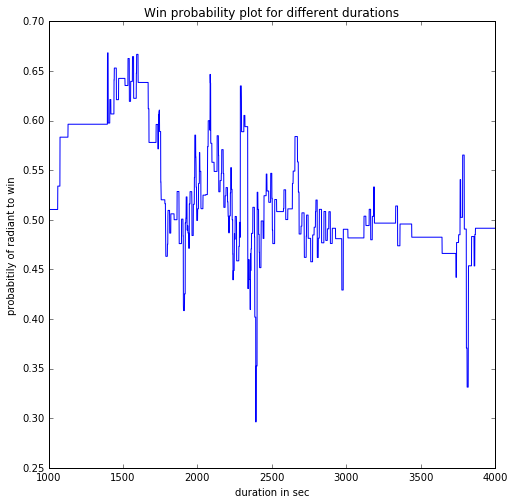

In [41]:
figsize(8,8)
try_match = np.copy(X_high[test_ind[1] ,:])
try_match = np.tile(try_match, [3000,1])
x_ = np.arange(1000,4000)
try_match[:,-1] = x_
y_ = bst.predict(xgb.DMatrix(try_match))
plt.plot(x_, y_)
plt.title('Win probability plot for different durations')
plt.xlabel('duration in sec')
plt.ylabel('probabitily of radiant to win')

### CV on xgboost without duration

In [17]:
dtrain = xgb.DMatrix(X_high[:, :-1], label = y_high)
param = {'bst:max_depth':5, 'bst:eta':0.4, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'logloss'
num_round = 200
bst = xgb.cv(param, dtrain, num_round, nfold=5, as_pandas = True, seed = 0)

In [18]:
print bst.iloc[::10, :]

     test-logloss-mean  test-logloss-std  train-logloss-mean  \
0             0.684722          0.000188            0.684761   
10            0.668158          0.000238            0.667148   
20            0.662425          0.000302            0.660551   
30            0.659086          0.000311            0.656346   
40            0.656694          0.000324            0.653188   
50            0.655121          0.000286            0.650776   
60            0.653975          0.000321            0.648856   
70            0.653119          0.000343            0.647250   
80            0.652371          0.000370            0.645876   
90            0.651901          0.000397            0.644653   
100           0.651466          0.000461            0.643545   
110           0.651054          0.000366            0.642449   
120           0.650792          0.000415            0.641513   
130           0.650569          0.000447            0.640618   
140           0.650309          0.000479

### Create table of results

In [3]:
import pickle

#### Make shuffle split and save it

In [63]:
cv = ShuffleSplit(n=X_very_high.shape[0], n_iter=5, random_state=123, test_size=0.2)
with open('CV_very_high.pkl', 'w+') as f:
    pickle.dump(cv, f)
    
cv = ShuffleSplit(n=X_high.shape[0], n_iter=5, random_state=123, test_size=0.2)
with open('CV_high.pkl', 'w+') as f:
    pickle.dump(cv, f)
    
cv = ShuffleSplit(n=X_normal.shape[0], n_iter=5, random_state=123, test_size=0.2)
with open('CV_normal.pkl', 'w+') as f:
    pickle.dump(cv, f)

In [14]:
def get_preds_lr(X_tr, y_tr, X_test):
    lr = LogisticRegression()
    lr.fit(X_tr, y_tr)
    return lr.predict_proba(X_test)[:,1]

def get_preds_xgboost(X_tr, y_tr, X_test):
    dtrain = xgb.DMatrix(X_tr, label = y_tr)
    param = {'bst:max_depth':5, 'bst:eta':0.4, 'silent':1, 'objective':'binary:logistic' }
    param['nthread'] = 4
    param['eval_metric'] = ['auc', 'logloss']
#     evallist  = [(dtest,'eval'), (dtrain,'train')]
    num_round = 300
    bst = xgb.train( param, dtrain, num_round, verbose_eval = 100 )
    return bst.predict(xgb.DMatrix(X_test))

def get_preds_dummy(X_tr, y_tr, X_test):
    dm = DummyClassifier('prior')
    dm.fit(X_tr,y_tr)
    return dm.predict_proba(X_test)[:,1]

def get_preds_FM(X_tr, y_tr, X_test):
    fm = mcmc.FMClassification(n_iter=50, rank=30)
    return fm.fit_predict_proba(csr_matrix(X_tr), y_tr, csr_matrix(X_test))

def get_preds_NB(X_tr, y_tr, X_test):
    gnb = BernoulliNB()
    return gnb.fit(X_tr, y_tr).predict_proba(X_test)[:,1]

def update_data(data, method, skill, fold, auc, logloss):
    data['method'].append(method)
    data['skill'].append(skill)
    data['fold'].append(fold)
    data['auc'].append(auc)
    data['log_loss'].append(logloss)
    return data

def runCV(X, y, cv, data, method, skill, get_predictions):
    fold = 0
    for tr, test in cv:
        preds = get_predictions(X[tr, :], y[tr], X[test, :])
        logloss = log_loss(y[test], preds)
        auc = roc_auc_score(y[test], preds)
        print 'auc = %f, logloss = %f' % (auc, logloss)
        data = update_data(data, method, skill, fold, auc, logloss)
    
        fold += 1
    
    return data
    
def get_preds_1_fold(X, y, cv, data, method, skill, get_predictions):
    for tr, test in cv:
        preds = get_predictions(X[tr, :], y[tr], X[test, :])
        return preds

#### Log regression with features : double Bag Of Words (one for rad team, one for dire)

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss

data = {}
data['method'] = []
data['skill'] = []
data['fold'] = []
data['auc'] = []
data['log_loss'] = []
method  = 'LR_2_BoW'

with open('CV_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X_high = X_high[:, :226] # drop duration from features
skill = 'High'
data = runCV(X_high, y_high, cv, data, method, skill, get_preds_lr)

with open('CV_very_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X_very_high = X_very_high[:, :226] # drop duration from features
skill = 'Very_High'
data = runCV(X_very_high, y_very_high, cv, data, method, skill, get_preds_lr)
    
with open('CV_normal.pkl', 'r') as f:
    cv = pickle.load(f)
    
X_normal = X_normal[:, :226] # drop duration from features
skill = 'Normal'
data = runCV(X_normal, y_normal, cv, data, method, skill, get_preds_lr)

df = pd.DataFrame.from_records(data)
df.to_csv(method + '.csv', index = False)

#### Log regression with hero features : 1 for rad hero, -1 for dire hero

In [53]:
data = {}
data['method'] = []
data['skill'] = []
data['fold'] = []
data['auc'] = []
data['log_loss'] = []
method  = 'LR_1'

with open('CV_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X = X_high[:, :113] - X_high[:, 113:] # drop duration from features
skill = 'High'
data = runCV(X, y_high, cv, data, method, skill, get_preds_lr)

with open('CV_very_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X = X_very_high[:,:113] - X_very_high[:, 113:] # drop duration from features
skill = 'Very_High'
data = runCV(X, y_very_high, cv, data, method, skill, get_preds_lr)
    
with open('CV_normal.pkl', 'r') as f:
    cv = pickle.load(f)
    
X = X_normal[:, :113] - X_normal[:,113:] # drop duration from features
skill = 'Normal'
data = runCV(X, y_normal, cv, data, method, skill, get_preds_lr)

df = pd.DataFrame.from_records(data)
df.to_csv(method + '.csv', index = False)

auc = 0.656041, logloss = 0.653562
auc = 0.655015, logloss = 0.653908
auc = 0.655378, logloss = 0.654018
auc = 0.656829, logloss = 0.653231
auc = 0.655398, logloss = 0.653869
auc = 0.644136, logloss = 0.659409
auc = 0.642386, logloss = 0.660218
auc = 0.642838, logloss = 0.660144
auc = 0.642864, logloss = 0.659995
auc = 0.643327, logloss = 0.659680
auc = 0.686881, logloss = 0.634862
auc = 0.687393, logloss = 0.634657
auc = 0.687118, logloss = 0.634816
auc = 0.687887, logloss = 0.634382
auc = 0.686697, logloss = 0.634984


#### xgboost

In [54]:
%%time
import xgboost as xgb

data = {}
data['method'] = []
data['skill'] = []
data['fold'] = []
data['auc'] = []
data['log_loss'] = []
method  = 'XGBoost'

with open('CV_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X = X_high[:, :226] # drop duration from features
skill = 'High'
data = runCV(X, y_high, cv, data, method, skill, get_preds_xgboost)

with open('CV_very_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X = X_very_high[:,:226] # drop duration from features
skill = 'Very_High'
data = runCV(X, y_very_high, cv, data, method, skill, get_preds_xgboost)
    
with open('CV_normal.pkl', 'r') as f:
    cv = pickle.load(f)
    
X = X_normal[:, :226] # drop duration from features
skill = 'Normal'
data = runCV(X, y_normal, cv, data, method, skill, get_preds_xgboost)

df = pd.DataFrame.from_records(data)
df.to_csv(method + '.csv', index = False)

auc = 0.664659, logloss = 0.649048
auc = 0.663731, logloss = 0.649400
auc = 0.663773, logloss = 0.649543
auc = 0.664423, logloss = 0.648929
auc = 0.664102, logloss = 0.649339
auc = 0.654333, logloss = 0.654212
auc = 0.653892, logloss = 0.654373
auc = 0.653591, logloss = 0.654734
auc = 0.653398, logloss = 0.654701
auc = 0.654278, logloss = 0.654101
auc = 0.701031, logloss = 0.625551
auc = 0.701112, logloss = 0.625635
auc = 0.700805, logloss = 0.625692
auc = 0.701878, logloss = 0.625126
auc = 0.700667, logloss = 0.625865
CPU times: user 1h 53min 22s, sys: 38.1 s, total: 1h 54min
Wall time: 29min 54s


In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, log_loss

data = {}
data['method'] = []
data['skill'] = []
data['fold'] = []
data['auc'] = []
data['log_loss'] = []
method  = 'Dummy'

with open('CV_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X_high = X_high[:, :226] # drop duration from features
skill = 'High'
data = runCV(X_high, y_high, cv, data, method, skill, get_preds_dummy)

with open('CV_very_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X_very_high = X_very_high[:, :226] # drop duration from features
skill = 'Very_High'
data = runCV(X_very_high, y_very_high, cv, data, method, skill, get_preds_dummy)
    
with open('CV_normal.pkl', 'r') as f:
    cv = pickle.load(f)
    
X_normal = X_normal[:, :226] # drop duration from features
skill = 'Normal'
data = runCV(X_normal, y_normal, cv, data, method, skill, get_preds_dummy)

df = pd.DataFrame.from_records(data)
df.to_csv(method + '.csv', index = False)

#### Try to add more features - roles of heroes in each team

In [26]:
roles = pd.read_csv('heroes_dotabuff.csv', index_col = 'id')
roles_data = np.zeros([113,9])
roles_data[roles.index - 1] = roles.as_matrix()[:,3:12]

def add_role_features(X):
    new_feat_rad = X[:,:113].dot(roles_data)
    new_feat_dire = X[:,113:].dot(roles_data)
    
    return np.concatenate((X, np.array(new_feat_rad), np.array(new_feat_dire)), axis = 1)

In [ ]:
import xgboost as xgb

data = {}
data['method'] = []
data['skill'] = []
data['fold'] = []
data['auc'] = []
data['log_loss'] = []
method  = 'XGBoost_roles'

with open('CV_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X = add_role_features(X_high[:, :226]) # drop duration from features
skill = 'High'
data = runCV(X, y_high, cv, data, method, skill, get_preds_xgboost)

with open('CV_very_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X = add_role_features(X_very_high[:, :226]) # drop duration from features
skill = 'Very_High'
data = runCV(X, y_very_high, cv, data, method, skill, get_preds_xgboost)
    
with open('CV_normal.pkl', 'r') as f:
    cv = pickle.load(f)
    
X = add_role_features(X_normal[:, :226]) # drop duration from features
skill = 'Normal'
data = runCV(X, y_normal, cv, data, method, skill, get_preds_xgboost)

df = pd.DataFrame.from_records(data)
df.to_csv(method + '.csv', index = False)

In [ ]:
with open('CV_normal.pkl', 'r') as f:
    cv = pickle.load(f)
    
X = add_role_features(X_normal[:, :226]) # drop duration from features
skill = 'Normal'
data = runCV(X, y_normal, cv, data, method, skill, get_preds_xgboost)

df = pd.DataFrame.from_records(data)
df.to_csv(method + '.csv', index = False)

auc = 0.701591, logloss = 0.625161
auc = 0.701625, logloss = 0.625196
auc = 0.701615, logloss = 0.625133
auc = 0.702601, logloss = 0.624584

In [70]:
del X

#### libFM

In [ ]:
from fastFM import mcmc
from scipy.sparse import csr_matrix

data = {}
data['method'] = []
data['skill'] = []
data['fold'] = []
data['auc'] = []
data['log_loss'] = []
method  = 'libFM'

with open('CV_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X_high = X_high[:, :226] # drop duration from features
skill = 'High'
data = runCV(X_high, y_high, cv, data, method, skill, get_preds_FM)

with open('CV_very_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X_very_high = X_very_high[:, :226] # drop duration from features
skill = 'Very_High'
data = runCV(X_very_high, y_very_high, cv, data, method, skill, get_preds_FM)
    
with open('CV_normal.pkl', 'r') as f:
    cv = pickle.load(f)
    
X_normal = X_normal[:, :226] # drop duration from features
skill = 'Normal'
data = runCV(X_normal, y_normal, cv, data, method, skill, get_preds_FM)

df = pd.DataFrame.from_records(data)
df.to_csv(method + '.csv', index = False)

### Naive Bayes

In [23]:
import pickle
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score, log_loss

data = {}
data['method'] = []
data['skill'] = []
data['fold'] = []
data['auc'] = []
data['log_loss'] = []
method  = 'NaiveBayes'

with open('CV_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X_high = X_high[:, :226] # drop duration from features
skill = 'High'
data = runCV(X_high, y_high, cv, data, method, skill, get_preds_NB)

with open('CV_very_high.pkl', 'r') as f:
    cv = pickle.load(f)
    
X_very_high = X_very_high[:, :226] # drop duration from features
skill = 'Very_High'
data = runCV(X_very_high, y_very_high, cv, data, method, skill, get_preds_NB)
    
with open('CV_normal.pkl', 'r') as f:
    cv = pickle.load(f)
    
X_normal = X_normal[:, :226] # drop duration from features
skill = 'Normal'
data = runCV(X_normal, y_normal, cv, data, method, skill, get_preds_NB)

df = pd.DataFrame.from_records(data)
df.to_csv(method + '.csv', index = False)


auc = 0.653430, logloss = 0.655135
auc = 0.652499, logloss = 0.655442
auc = 0.652842, logloss = 0.655604
auc = 0.654556, logloss = 0.654622
auc = 0.653086, logloss = 0.655326
auc = 0.641189, logloss = 0.661189
auc = 0.639809, logloss = 0.661870
auc = 0.639903, logloss = 0.661966
auc = 0.640402, logloss = 0.661607
auc = 0.641365, logloss = 0.661034
auc = 0.684866, logloss = 0.636103
auc = 0.685576, logloss = 0.635759
auc = 0.685097, logloss = 0.636081
auc = 0.685981, logloss = 0.635531
auc = 0.684732, logloss = 0.636204


### get preds for 1st fold and write them

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss

import xgboost as xgb

from fastFM import mcmc
from scipy.sparse import csr_matrix

import pickle
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score, log_loss

from sklearn.dummy import DummyClassifier

In [31]:
def write_preds(method, get_preds_function):
    with open('CV_high.pkl', 'r') as f:
        cv = pickle.load(f)
    skill = 'High'
    preds = get_preds_1_fold(X_high, y_high, cv, [], method, skill, get_preds_function)
    with open('preds/' + method + skill + '_preds.pkl', 'w+') as f:
        pickle.dump(preds, f)

    with open('CV_very_high.pkl', 'r') as f:
        cv = pickle.load(f)
    skill = 'Very_High'
    preds = get_preds_1_fold(X_very_high, y_very_high, cv, [], method, skill, get_preds_function)
    with open('preds/' + method + skill + '_preds.pkl', 'w+') as f:
        pickle.dump(preds, f)

    with open('CV_normal.pkl', 'r') as f:
        cv = pickle.load(f)
    skill = 'Normal'
    preds = get_preds_1_fold(X_normal, y_normal, cv, [], method, skill, get_preds_function)
    with open('preds/' + method + skill + '_preds.pkl', 'w+') as f:
        pickle.dump(preds, f)
        
def write_preds_with_update(method, get_preds_function, update_function):
    with open('CV_high.pkl', 'r') as f:
        cv = pickle.load(f)
    skill = 'High'
    preds = get_preds_1_fold(update_function(X_high), y_high, cv, [], method, skill, get_preds_function)
    with open('preds/' + method + skill + '_preds.pkl', 'w+') as f:
        pickle.dump(preds, f)

    with open('CV_very_high.pkl', 'r') as f:
        cv = pickle.load(f)
    skill = 'Very_High'
    preds = get_preds_1_fold(update_function(X_very_high), y_very_high, cv, [], method, skill, get_preds_function)
    with open('preds/' + method + skill + '_preds.pkl', 'w+') as f:
        pickle.dump(preds, f)

    with open('CV_normal.pkl', 'r') as f:
        cv = pickle.load(f)
    skill = 'Normal'
    preds = get_preds_1_fold(update_function(X_normal), y_normal, cv, [], method, skill, get_preds_function)
    with open('preds/' + method + skill + '_preds.pkl', 'w+') as f:
        pickle.dump(preds, f)


In [32]:
%%time
method  = 'NaiveBayes'
write_preds(method, get_preds_NB)

CPU times: user 29.3 s, sys: 14.7 s, total: 44 s
Wall time: 43 s


In [33]:
%%time
method  = 'XGBoost'
write_preds(method, get_preds_xgboost)

CPU times: user 19min 33s, sys: 9.22 s, total: 19min 42s
Wall time: 5min 12s


In [34]:
%%time
method  = 'LR_2_BoW'
write_preds(method, get_preds_lr)

CPU times: user 45.6 s, sys: 5.62 s, total: 51.3 s
Wall time: 51.5 s


In [35]:
%%time
method  = 'Dummy'
write_preds(method, get_preds_dummy)

CPU times: user 4.66 s, sys: 3.87 s, total: 8.54 s
Wall time: 8.55 s


In [36]:
%%time
method  = 'XGBoost_roles'
write_preds_with_update(method, get_preds_xgboost, add_role_features)

CPU times: user 55min 28s, sys: 18.9 s, total: 55min 47s
Wall time: 15min 11s


In [38]:
%%time
method  = 'LR_1'
write_preds_with_update(method, get_preds_lr, lambda data : data[:, :113] - data[:, 113:])

CPU times: user 56.4 s, sys: 6.22 s, total: 1min 2s
Wall time: 1min 2s


In [ ]:
%%time
method  = 'libFM'
write_preds(method, get_preds_FM)

CPU times: user 1h 21min 33s, sys: 20.3 s, total: 1h 21min 53s
Wall time: 1h 21min 53s


In [12]:
!ls preds/

DummyHigh_preds.pkl	  LR_2_BoWVery_High_preds.pkl
DummyNormal_preds.pkl	  NaiveBayesHigh_preds.pkl
DummyVery_High_preds.pkl  NaiveBayesNormal_preds.pkl
libFMHigh_preds.pkl	  NaiveBayesVery_High_preds.pkl
libFMNormal_preds.pkl	  XGBoostHigh_preds.pkl
libFMVery_High_preds.pkl  XGBoostNormal_preds.pkl
LR_1High_preds.pkl	  XGBoost_rolesHigh_preds.pkl
LR_1Normal_preds.pkl	  XGBoost_rolesNormal_preds.pkl
LR_1Very_High_preds.pkl   XGBoost_rolesVery_High_preds.pkl
LR_2_BoWHigh_preds.pkl	  XGBoostVery_High_preds.pkl
LR_2_BoWNormal_preds.pkl


In [18]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


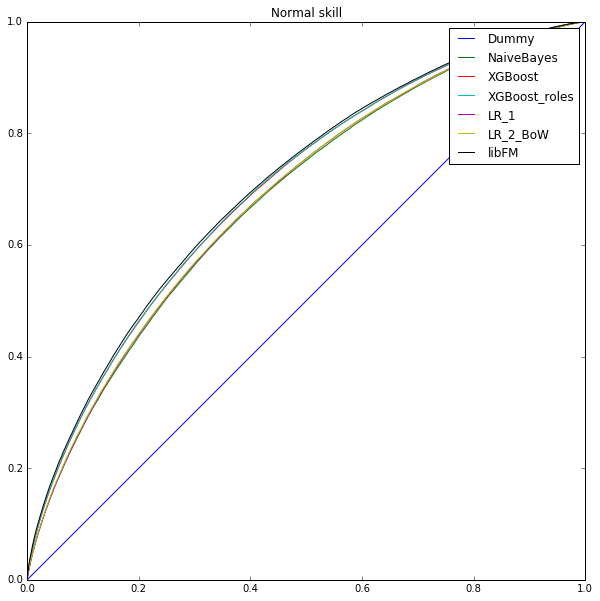

In [32]:
figsize(10,10)
import pickle
from sklearn.metrics import roc_curve
skill = 'Normal'
methods = ['Dummy', 'NaiveBayes', 'XGBoost', 'XGBoost_roles', 'LR_1', 'LR_2_BoW', 'libFM']
with open('CV_' + skill.lower() + '.pkl', 'r') as f:
    cv = pickle.load(f)
for tr, test in cv:
    y = y_normal[test]
    break

for method in methods:
    with open('preds/' + method + skill + '_preds.pkl', 'r') as f:
        preds = pickle.load(f)
    (fpr, tpr, thresholds) = roc_curve(y, preds)
    plt.plot(fpr, tpr, label = method)

plt.legend()
plt.title(skill + ' skill')
plt.show()

###Other

#### Tune parameters for xgboost

In [48]:
dtrain = xgb.DMatrix(add_role_features(X_high[:, :226]), label = y_high)
param = {'bst:max_depth':5, 'bst:eta':0.4, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'logloss'
num_round = 300
bst = xgb.cv(param, dtrain, num_round, nfold=5, as_pandas = True, seed = 0)

In [51]:
bst[250:310]

,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std
250,0.649202,0.000468,0.631645,0.000176
251,0.649201,0.000476,0.631576,0.000179
252,0.649193,0.000469,0.631503,0.000185
253,0.649189,0.000459,0.631435,0.000185
254,0.649181,0.000476,0.631368,0.000180
255,0.649175,0.000483,0.631296,0.000178
256,0.649178,0.000476,0.631234,0.000177
257,0.649161,0.000478,0.631166,0.000180
258,0.649156,0.000469,0.631098,0.000186
259,0.649151,0.000479,0.631039,0.000197


## Read results and make final table

In [62]:
libFM = pd.read_csv('libFM.csv')
libFM['log_loss'] = libFM['log_loss'] / np.log(2)

XGBoost = pd.read_csv('XGBoost.csv')
XGBoost['log_loss'] = XGBoost['log_loss'] / np.log(2)

XGBoost_roles = pd.read_csv('XGBoost_roles.csv')
XGBoost_roles['log_loss'] = XGBoost_roles['log_loss'] / np.log(2)

LR_1 = pd.read_csv('LR_1.csv')
LR_1['log_loss'] = LR_1['log_loss'] / np.log(2)

LR_2_BoW = pd.read_csv('LR_2_BoW.csv')
LR_2_BoW['log_loss'] = LR_2_BoW['log_loss'] / np.log(2)

NaiveBayes = pd.read_csv('NaiveBayes.csv')
NaiveBayes['log_loss'] = NaiveBayes['log_loss'] / np.log(2)

Dummy = pd.read_csv('Dummy.csv')
Dummy['log_loss'] = Dummy['log_loss'] / np.log(2)

tables = [libFM, XGBoost, XGBoost_roles, LR_1, LR_2_BoW, NaiveBayes, Dummy]

In [78]:
all_results = []

for table in tables:
    row = np.array([])
    for skill in ['Normal', 'High', 'Very_High']:
        row = np.concatenate((row, table[table['skill'] == skill][['auc', 'log_loss']].mean(axis = 0).values))
    all_results.append(row)
all_results = np.round(np.array(all_results), 3)



In [79]:
df = pd.DataFrame(all_results,
                  columns = ['auc', 'log_loss', 'auc', 'log_loss', 'auc', 'log_loss'],
                 index = ['libFM', 'XGBoost', 'XGBoost_roles', 'LR_1', 'LR_2_BoW', 'NaiveBayes', 'Dummy'])
df

,auc,log_loss,auc,log_loss,auc,log_loss
libFM,0.706,0.898,0.670,0.933,0.660,0.940
XGBoost,0.701,0.903,0.664,0.937,0.654,0.944
XGBoost_roles,0.702,0.902,0.663,0.938,0.653,0.945
LR_1,0.687,0.916,0.656,0.943,0.643,0.952
LR_2_BoW,0.688,0.915,0.656,0.943,0.643,0.952
NaiveBayes,0.685,0.917,0.653,0.945,0.641,0.954
Dummy,0.500,0.996,0.500,0.999,0.500,0.999


In [80]:
print df.to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &    auc &  log\_loss &    auc &  log\_loss &    auc &  log\_loss \\
\midrule
libFM         &  0.706 &     0.898 &  0.670 &     0.933 &  0.660 &     0.940 \\
XGBoost       &  0.701 &     0.903 &  0.664 &     0.937 &  0.654 &     0.944 \\
XGBoost\_roles &  0.702 &     0.902 &  0.663 &     0.938 &  0.653 &     0.945 \\
LR\_1          &  0.687 &     0.916 &  0.656 &     0.943 &  0.643 &     0.952 \\
LR\_2\_BoW      &  0.688 &     0.915 &  0.656 &     0.943 &  0.643 &     0.952 \\
NaiveBayes    &  0.685 &     0.917 &  0.653 &     0.945 &  0.641 &     0.954 \\
Dummy         &  0.500 &     0.996 &  0.500 &     0.999 &  0.500 &     0.999 \\
\bottomrule
\end{tabular}



In [45]:
libFM_row

array([ 0.70577985,  0.89837925,  0.67005168,  0.9325159 ,  0.65972517,
        0.94048252])

In [66]:
!ls *.csv

Dummy.csv	     libFM.csv	LR_2_BoW.csv	XGBoost.csv
heroes_dotabuff.csv  LR_1.csv	NaiveBayes.csv	XGBoost_roles.csv


In [43]:
libFM

,auc,fold,log_loss,method,skill
0,0.670384,0,0.932379,libFM,High
1,0.669126,1,0.932904,libFM,High
2,0.669729,2,0.932901,libFM,High
3,0.671029,3,0.931753,libFM,High
4,0.669990,4,0.932642,libFM,High
5,0.660070,0,0.940294,libFM,Very_High
6,0.658954,1,0.941063,libFM,Very_High
7,0.659079,2,0.940924,libFM,Very_High
8,0.660056,3,0.940339,libFM,Very_High
9,0.660466,4,0.939792,libFM,Very_High
